In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

# Create Table and Import Data

In [2]:
%%sql

DROP TYPE IF EXISTS expansion;
CREATE TYPE expansion AS ENUM ('KTK', 'LCI', 'WOE', 'LTR', 'MOM', 'SIR', 'ONE', 'BRO', 'DMU', 'HBG', 'SNC', 'NEO', 'VOW', 'MID', 'AFR', 'STX', 'KHM');
DROP TYPE IF EXISTS event_type;
CREATE TYPE event_type AS ENUM ('PremierDraft', 'TradDraft', 'Sealed', 'TradSealed');
DROP TYPE IF EXISTS rank;
CREATE TYPE rank AS ENUM ('silver', 'bronze', 'None', 'gold', 'platinum', 'diamond', 'mythic');
DROP TYPE IF EXISTS color;
CREATE TYPE color AS ENUM ('RG', 'UBG', 'WUB', 'UBR', 'WUBG', 'BG', 'WG', 'WBG', 'WUBRG', 'UR', 'UB', 'WBR', 'WRG', 'None', 'BR', 'WUBR', 'G', 'WR', 'W', 'WU', 'WB', 'WUR', 'WUG', 'WBRG', 'BRG', 'U', 'URG', 'UBRG', 'UG', 'B', 'R', 'WURG');

,Success


In [3]:
%%sql

DROP TABLE IF EXISTS game;

# https://www.17lands.com/history/<draft_id>/<match_number - 1>/<game_number - 1>
CREATE TABLE game (
    expansion expansion NOT NULL,
    event_type event_type NOT NULL,
    draft_id VARCHAR NOT NULL,
    draft_time TIMESTAMP_S NOT NULL,
    game_time TIMESTAMP_S NOT NULL,
    build_index TINYINT NOT NULL,
    match_number TINYINT NOT NULL,
    game_number TINYINT NOT NULL,
    rank rank,
    opp_rank rank NOT NULL,
    main_colors color NOT NULL,
    splash_colors color,
    on_play BOOLEAN NOT NULL,
    num_mulligans TINYINT NOT NULL,
    opp_num_mulligans TINYINT NOT NULL,
    opp_colors color,
    num_turns TINYINT NOT NULL,
    won BOOLEAN NOT NULL,
    user_n_games_bucket INTEGER NOT NULL,
    user_game_win_rate_bucket DOUBLE,
)

,Success


In [4]:
%%sql

INSERT INTO
    game
BY NAME
SELECT
    expansion, event_type, draft_id, draft_time, game_time, build_index, match_number, game_number, rank, opp_rank, main_colors, splash_colors, on_play, num_mulligans, opp_num_mulligans, opp_colors, num_turns, won, user_n_games_bucket, user_game_win_rate_bucket
FROM
    # 'https://17lands-public.s3.amazonaws.com/analysis_data/game_data/game_data_public.LCI.PremierDraft.csv.gz'
    '~/Downloads/game_data_public.LCI.PremierDraft.csv.gz'

,Success


In [5]:
%%sql

DROP INDEX IF EXISTS game_draft_match_game;
CREATE UNIQUE INDEX game_draft_match_game ON game (draft_id, match_number, game_number);

DROP INDEX IF EXISTS game_rank;
CREATE INDEX game_rank ON game (rank);

DROP INDEX IF EXISTS game_main_colors;
CREATE INDEX game_main_colors ON game (main_colors);

DROP INDEX IF EXISTS game_splash_colors;
CREATE INDEX game_splash_colors ON game (splash_colors);

DROP INDEX IF EXISTS game_on_play;
CREATE INDEX game_on_play ON game (on_play);

DROP INDEX IF EXISTS game_user_n_games_bucket;
CREATE INDEX game_user_n_games_bucket ON game (user_n_games_bucket);

DROP INDEX IF EXISTS game_user_win_rate_bucket;
CREATE INDEX game_user_win_rate_bucket ON game (user_game_win_rate_bucket);

,Success


# Check Distribution and Determine the Threshold to Filter Top Players

Top user

1. Win-rate is high enough.
2. Play enough many games so the win-rate is meaningful.

In [6]:
# Verified win-rate is not normal distribution
# scipy.stats.normaltest(df['user_game_win_rate_bucket'])

df = %sql SELECT median(user_n_games_bucket) AS median_user_n_games_bucket, median(user_game_win_rate_bucket) AS median_user_game_win_rate_bucket FROM game

user_n_games_threshold = df['median_user_n_games_bucket'][0]
user_game_win_rate_threshold = df['median_user_game_win_rate_bucket'][0]

print(f'user_n_games_threshold={user_n_games_threshold}, user_game_win_rate_threshold={user_game_win_rate_threshold}')

user_n_games_threshold=100.0, user_game_win_rate_threshold=0.54


```SQL
WHERE user_game_win_rate_bucket >= {{ win_rate_threshold }} AND user_n_games_bucket >= {{ user_n_games_threshold }}
```

# Analysis

<Axes: title={'center': 'Main Colors Distribution'}, ylabel='count'>

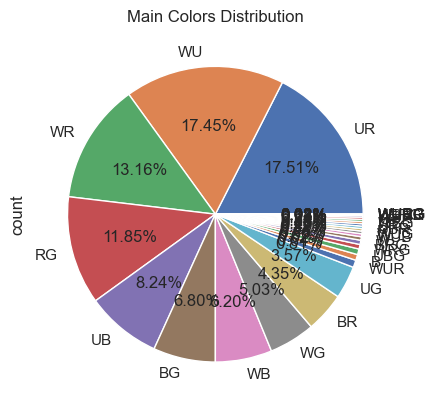

In [7]:
top_game = %sql SELECT main_colors, COUNT(*) AS count FROM game WHERE user_game_win_rate_bucket >= {{ user_game_win_rate_threshold }} AND user_n_games_bucket >= {{ user_n_games_threshold }} GROUP BY main_colors ORDER BY count DESC
top_game.set_index('main_colors', inplace=True)
top_game.plot.pie(y='count', autopct='%.2f%%', title='Main Colors Distribution', legend=False)

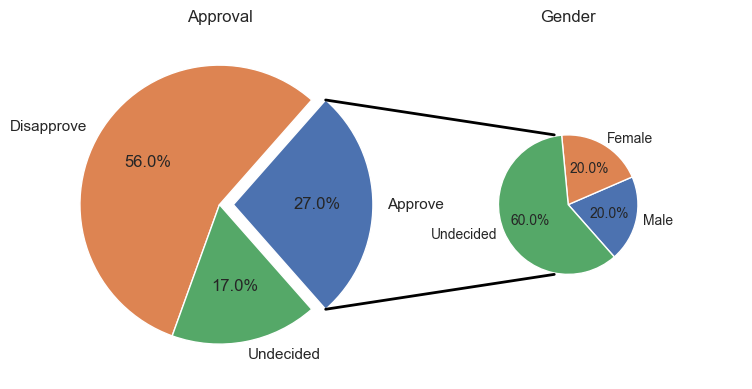

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np

# make figure and assign axis objects
fig = plt.figure(figsize=(9, 5.0625))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

# large pie chart parameters
ratios = [.27, .56, .17]
labels = ['Approve', 'Disapprove', 'Undecided']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode)

# small pie chart parameters
ratios = [.20, .20, .60]
labels = ['Male', 'Female', 'Undecided']
width = .2

ax2.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, radius=0.5, textprops={'size': 'smaller'})

ax1.set_title('Approval')
ax2.set_title('Gender')

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(- width / 2, .5), xyB=(x, y),
                      coordsA="data", coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(- width / 2, -.5), xyB=(x, y), coordsA="data",
                      coordsB="data", axesA=ax2, axesB=ax1)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()

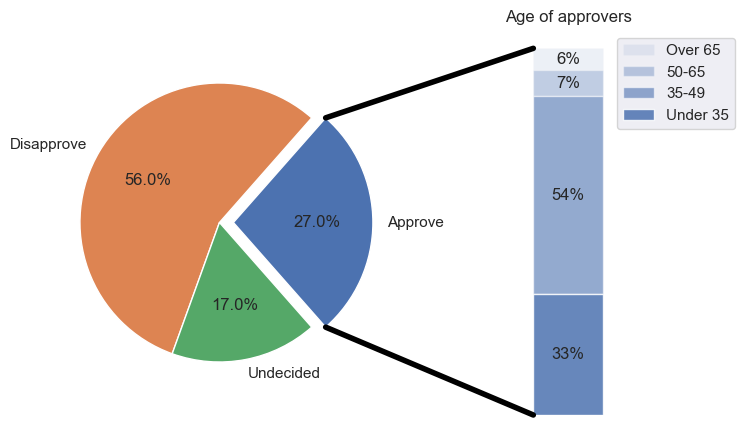

In [17]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import ConnectionPatch

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [.27, .56, .17]
labels = ['Approve', 'Disapprove', 'Undecided']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = [.33, .54, .07, .06]
age_labels = ['Under 35', '35-49', '50-65', 'Over 65']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Age of approvers')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()